# Topic modeling

After successfully identifying the negative sentiment tweets, there is further work to subcategorize our feedback from customers into several topics then sent them to the related departments. Once different departments get real-time customer feedback, they can respond to problems quickly and develop improvement plans to improve customer satisfaction effectively.

## What is topic modeling

In machine learning and natural language processing, a topic model is a type of statistical model for **discovering the abstract "topics" that occur in a collection of documents.**

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0360131520300555-gr2.jpg" />

In [2]:
import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
style.use('seaborn-white')
sns.set_context(context='talk')

import wordsegment
from wordsegment import load, segment

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [3]:
# Import Dataset
df = pd.read_csv('../dataset/Tweets.csv')
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


## The ground truth

In [4]:
df.negativereason.unique()

array([nan, 'Bad Flight', "Can't Tell", 'Late Flight',
       'Customer Service Issue', 'Flight Booking Problems',
       'Lost Luggage', 'Flight Attendant Complaints', 'Cancelled Flight',
       'Damaged Luggage', 'longlines'], dtype=object)

Negative reasons can be roughly grouped into 4 categories
1. Flight related problems : "Bad Flight", "Late Flight", "Cancelled Flight"
1. Customer services : "Customer Serviece Issue", "Flight Attendant Complaints", "longlines"
1. Booking problems : "Flight Booking Problems"
1. Luggage related problems : "Lost Luggage", "Damaged Luggage"

In [5]:
df = df[df['airline_sentiment'] == 'negative'][['text', 'negativereason']]
df.head()

,text,negativereason
3,@VirginAmerica it's really aggressive to blast...,Bad Flight
4,@VirginAmerica and it's a really big bad thing...,Can't Tell
5,@VirginAmerica seriously would pay $30 a fligh...,Can't Tell
15,@VirginAmerica SFO-PDX schedule is still MIA.,Late Flight
17,@VirginAmerica I flew from NYC to SFO last we...,Bad Flight


In [7]:
def group_reason(reason):
    if reason in ["Bad Flight", "Late Flight", "Cancelled Flight"]:
        return "Flight related problems"
    elif reason in ["Customer Service Issue", "Flight Attendant Complaints", "longlines"]:
        return "Customer services problems"
    elif reason in ["Flight Booking Problems"]:
        return "Booking problems"
    elif reason in ["Lost Luggage", "Damaged Luggage"]:
        return "Luggage related problems"
    else:
        return "Unidentified"

Text(0.5, 0, '')

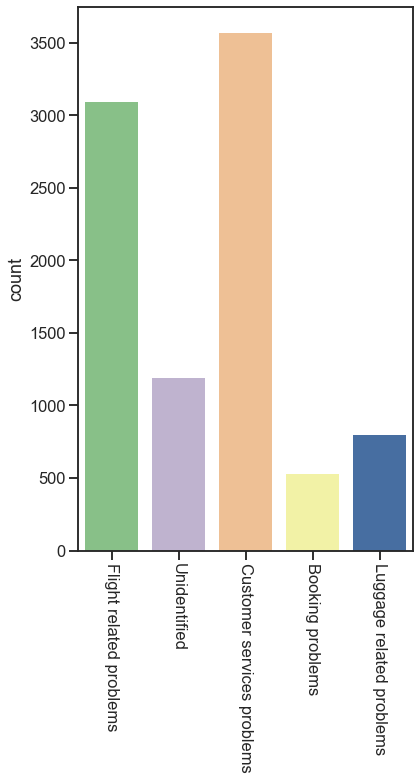

In [11]:
df["grouped_reason"] = df['negativereason'].apply(group_reason)
plt.figure(figsize=(6,10))
g = sns.countplot(data=df, x='grouped_reason', palette='Accent')
g.set_xticklabels(g.get_xticklabels(), rotation = 270)
g.set_xlabel("")

Majority of the complaint related to customer services problems, while flight related problems is the second in line.

In [9]:
# Text preprocessing function that we used in our sentiment analysis notebook

def cleaning(text):
    """
    Take a raw tweet as input then clean it into ready-to-use text
    """
    
    # 1. Convert all text to lowercase,
    lower = text.lower()
    
    # 2. Remove hyperlink and special characters except hash sign
    no_html = re.sub(r'(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', '', lower)
    letters_only = re.sub("[^#a-zA-Z0-9]", " ", no_html).split()
    
    # 3. Segmenting hashtags
    normal_words = [word for word in letters_only if (word.startswith("#") == False)]
    hashtag_words = [word for word in letters_only if word.startswith("#")]
    hashtag_split = [segment(hashtag) for hashtag in hashtag_words]
    nohash_words = []
    count = 0
    for word in letters_only:
        if word not in hashtag_words:
            nohash_words.append(word)
        else:
            nohash_words.extend(hashtag_split[count])
            count += 1
    
    # 4. Remove mentioning specific airlines
    airline = ['virginamerica', 'united', 'unitedairways', 'southwest', 'southwestair' 'delta', 'usairways',
       'american','americanair','jetblue',]
    useful_words = [word for word in nohash_words if word not in airline]
    
    # 5. remove stopwords
    stops = set(stopwords.words('english'))
    meaningful_words = [word for word in useful_words if word not in stops]
    
    return meaningful_words

In [10]:
# load the hashtag segmentation module
load()

# Applying cleaning function
data = df['text'].to_list()
data_words = df['text'].apply(cleaning).to_list()
data_words[2]

['seriously',
 'would',
 'pay',
 '30',
 'flight',
 'seats',
 'playing',
 'really',
 'bad',
 'thing',
 'flying',
 'va']

## Model building

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [12]:
len(data_ready)

9178

In [13]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.170*"flight" + 0.064*"cancel" + 0.034*"tomorrow" + 0.024*"amp" + '
  '0.023*"delay" + 0.023*"bad" + 0.017*"flightle" + 0.016*"flightled" + '
  '0.016*"gate" + 0.016*"dfw"'),
 (1,
  '0.044*"aa" + 0.036*"agent" + 0.030*"time" + 0.025*"plane" + 0.025*"tell" + '
  '0.023*"weather" + 0.019*"seat" + 0.018*"work" + 0.015*"guy" + '
  '0.015*"luggage"'),
 (2,
  '0.056*"help" + 0.056*"hour" + 0.040*"hold" + 0.036*"phone" + 0.025*"bag" + '
  '0.021*"ticket" + 0.020*"leave" + 0.017*"reservation" + 0.017*"minute" + '
  '0.016*"rebooke"'),
 (3,
  '0.090*"call" + 0.045*"customer" + 0.044*"wait" + 0.044*"service" + '
  '0.026*"still" + 0.023*"airport" + 0.022*"day" + 0.016*"back" + '
  '0.014*"issue" + 0.013*"response"')]


In [14]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5461,"aa, agent, time, plane, tell, weather, seat, w...","[really, aggressive, blast, obnoxious, enterta..."
1,1,0.0,0.6500,"flight, cancel, tomorrow, amp, delay, bad, fli...","[really, big, bad, thing]"
2,2,0.0,0.7240,"flight, cancel, tomorrow, amp, delay, bad, fli...","[seriously, pay, flight, seat, play, really, b..."
3,3,0.0,0.4448,"flight, cancel, tomorrow, amp, delay, bad, fli...","[sfo, schedule, still, mia]"
4,4,1.0,0.5984,"aa, agent, time, plane, tell, weather, seat, w...","[fly, nyc, sfo, last, week, fully, sit, seat, ..."
5,5,1.0,0.7831,"aa, agent, time, plane, tell, weather, seat, w...","[first, fare, time, carrier, seat, available, ..."
6,6,1.0,0.5761,"aa, agent, time, plane, tell, weather, seat, w...","[guy, mess, seating, reserve, seating, friend,..."
7,7,3.0,0.7757,"call, customer, wait, service, still, airport,...","[status_match, program, apply, week, call, ema..."
8,8,3.0,0.5738,"call, customer, wait, service, still, airport,...","[happen, vegan, food, option, least, ur, site,..."
9,9,0.0,0.4108,"flight, cancel, tomorrow, amp, delay, bad, fli...","[amazing, cold, air, vent, air, bad, flight, e..."


## Result

In [15]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9296,"flight, cancel, tomorrow, amp, delay, bad, flightle, flightled, gate, dfw","[spiritairpr, fioretti, ndward, chicagosmayor, garcia, chicago, noise, late, flight, norah]"
1,1.0,0.9417,"aa, agent, time, plane, tell, weather, seat, work, guy, luggage","[feb, ground, power, short, third, time, weary, german, passenger, deplane, jealous, auf, wieder..."
2,2.0,0.9374,"help, hour, hold, phone, bag, ticket, leave, reservation, minute, rebooke","[serve, rubber, pasta, cover, sauce, taste, plastic, food, human, consumption, anymore]"
3,3.0,0.9331,"call, customer, wait, service, still, airport, day, back, issue, response","[irony, dog, spot, bark, wait, area, front, send, cocktail, coupon, stat]"


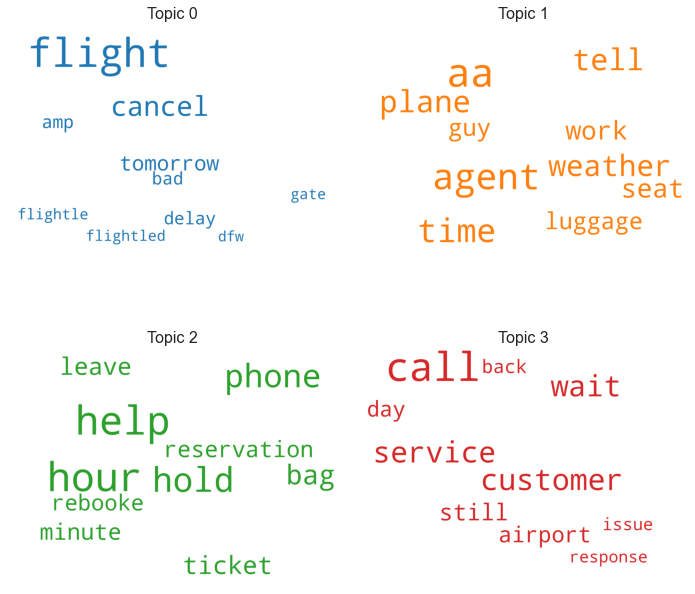

In [16]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Findings:
1. Topic 0 : could be flight related problems since it contains keywords ['flight', 'delay']
1. Topic 1 : could be luggage related problem since it includes keywords ['luggage', 'agent']
1. Topic 2 : could be reservation / ticketing problems because it have related keywords such as ['reservation', 'phone', 'ticket']
1. Topic 3 : could be customer services problems since it contains ['call', 'service', 'customer', 'response']

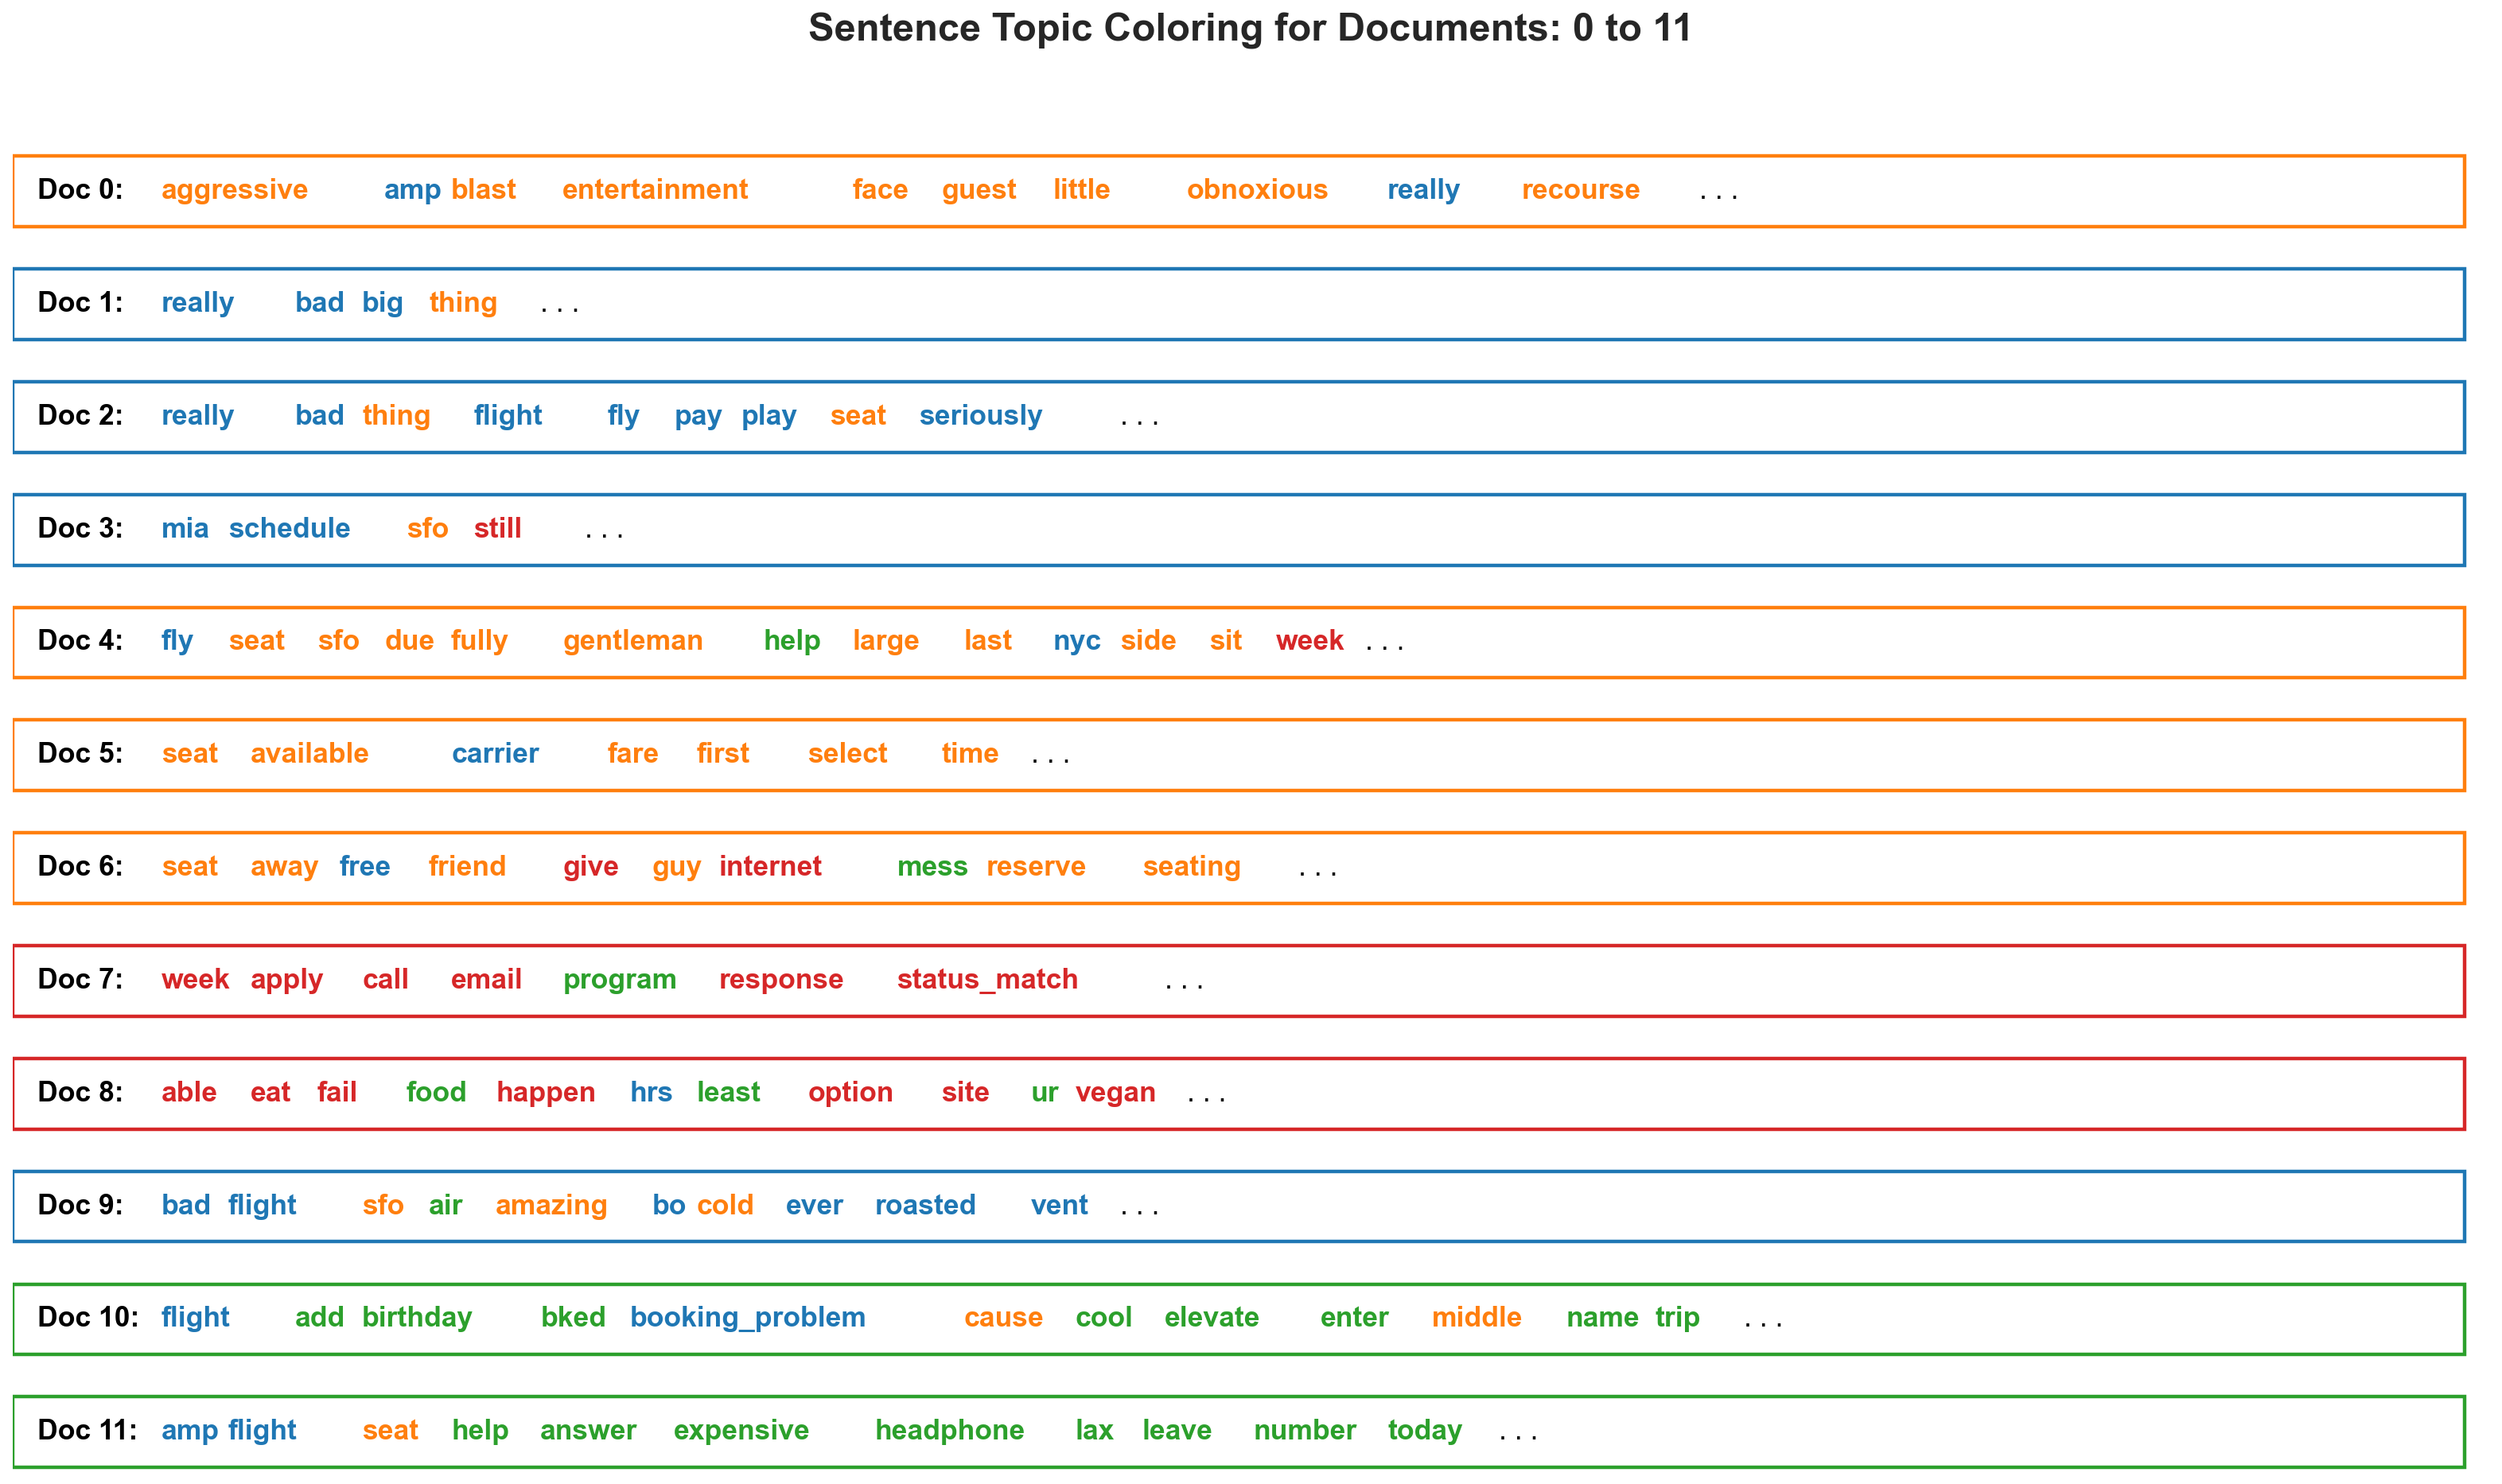

In [17]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
#             print(wordid_topics)
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()  

In [18]:
df_dominant_topic[df_dominant_topic['Document_No']==3]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
3,3,0.0,0.4448,"flight, cancel, tomorrow, amp, delay, bad, flightle, flightled, gate, dfw","[sfo, schedule, still, mia]"


## Conclusion and future works

In [19]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.342496 -0.060849       1        1  30.222162
1     -0.037008  0.190145       2        1  23.346050
2     -0.170269 -0.296556       3        1  23.238416
3     -0.135219  0.167260       4        1  23.193371, topic_info=       Term         Freq        Total Category  logprob  loglift
13   flight  3716.000000  3716.000000  Default  30.0000  30.0000
49     call  1513.000000  1513.000000  Default  29.0000  29.0000
148  cancel  1407.000000  1407.000000  Default  28.0000  28.0000
26     help   948.000000   948.000000  Default  27.0000  27.0000
117    hour   948.000000   948.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
56     fail    96.713277    97.428211   Topic4  -5.1545   1.4539
952    high    93.770112    94.473307   Topic4  -5.1854   1.4538
803    care    92.864965    93.561528   Topic4  -5.1951   1.4538
58   happen    89.769507    90.486105   Topic4  -5.2290   1.4534
191     buy    96.448201    97.246054   Topic4  -5.1573   1.4531

[156 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1830      2  0.998785         aa
303       2  0.998852      agent
128       1  0.997158    airline
304       4  0.998188    airport
1567      2  0.985465     almost
...     ...       ...        ...
171       2  0.994265    website
297       4  0.993584       well
174       2  0.997673       work
344       1  0.997916      wrong
238       4  0.996378  yesterday

[129 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

- The modeling result quite accurate, although topic 2 and 4 are somewhat overlapping. 
- I have tried to increase number of topics, and it result in more ambiguous outcomes (3-4 overlapping topics), therefore I believe the optimum number of topics for our data is 4
- The future scope of this project will be including building a topic classifier to filter negative feedback into several topic then redirect them to different teams.
- In the future, if we got more data, it is possible that the suitable number of topic may change. At that time, we can recluster them and retrain the topic classifier.